In [1]:
dependencies = [
    "kagtool",
    "kaggle",
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

In [2]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.tabular.core import *

# DataBlock From Scratch

In [3]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images'),Path('/Users/cactus/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
file_names = get_image_files(path/"images")
file_names[0]

Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg')

In [5]:
dblock = DataBlock()
dblock
# a datablock is a blueprint on how to assemble your data, by default it doesn't do anything

In [6]:
# we can convert the datablock to a dataloader or a dataset
dsets = dblock.datasets(file_names)
dsets.train[0]

# first row of train should give us the x but also the y, but we didn't specify the y yet so it's the same

(Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_194.jpg'),
 Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_194.jpg'))

In [7]:
def get_label(fname):
    return "cat" if fname.name[0].isupper() else "dog"

In [8]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = get_label)

dsets = dblock.datasets(path/"images")
dsets.train[0]

# we now get our y

(Path('/Users/cactus/.fastai/data/oxford-iiit-pet/images/Bombay_14.jpg'),
 'cat')

In [9]:
# we can't convert to a dataloader yet, because we haven't specified how to load the data yet!
try:
    dls = dblock.dataloaders(file_names)
except Exception as e:
    print(e)

argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'L'


In [10]:
# at this point we haven't specified how to transform the x and y into usefull format for our future model, so let's do that
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = get_label)

dsets = dblock.datasets(path/"images")
dsets.train[0]
# now x has been turn into an image, and y has been turn into a category

(PILImage mode=RGB size=500x328, TensorCategory(0))

In [11]:
# we also created a vocab for the labels
dsets.vocab

['cat', 'dog']

In [12]:
# we need to specify how we want to split the data for training and validation
# Let's start with a RandomSplitter, but you should be careful for example in time series data, that's not what you want


# by default it's 80% train and 20% valid, but you can change that
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = get_label,
                   splitter  = RandomSplitter(valid_pct=0.3))

dsets = dblock.datasets(path/"images")
len(dsets.train), len(dsets.valid)

(5173, 2217)

In [13]:
# the last step is to specify further preprocessing we want to apply to our data
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = get_label,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))
                   # batch_tfms=aug_transforms(size=(240,320))) doesn't work without a GPU

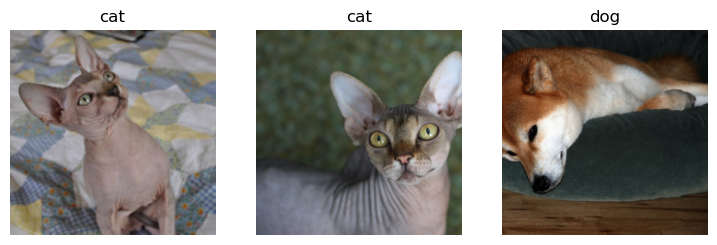

In [14]:
dls = dblock.dataloaders(path/"images")
dls.show_batch(max_n=3)

In [15]:
# we can get a summary of how our data was processed
dblock.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/cactus/.fastai/data/oxford-iiit-pet/images/basset_hound_36.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: get_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/cactus/.fastai/data/oxford-iiit-pet/images/basset_hound_36.jpg
    applying get_label gives
      dog
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(1))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Se

__The DataBlock basically help us answer these questions for the model__:
- what is the types of your inputs/targets? Here images and categories
- where is your data? Here in filenames in subfolders
- does something need to be applied to inputs? Here no
- does something need to be applied to the target? Here the label_func function
- how to split the data? Here randomly
- do we need to apply something on formed items? Here a resize
- do we need to apply something on formed batches? Here no


In [16]:
# And here's the code for the above questions
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = get_label,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

# if we needed to processthe inputs we would add a get_x = process_inputs_func
# if we needed to apply a transform on batches we would add a batch_tfms=aug_transforms(size=(240,320)

# Image Classification

### MNIST - Single Label

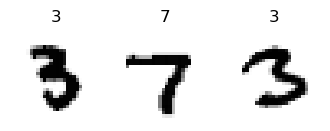

In [17]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = dblock.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=3, figsize=(4,4))

### Pets - Single Label

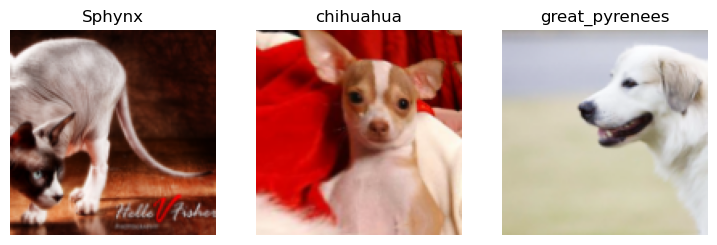

In [18]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

dls = dblock.dataloaders(untar_data(URLs.PETS)/"images", device='cpu')
dls.show_batch(max_n=3)

### Pascal - Image Classification - Multi-Label

In [19]:
pascal_source = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(pascal_source/"train.csv")
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


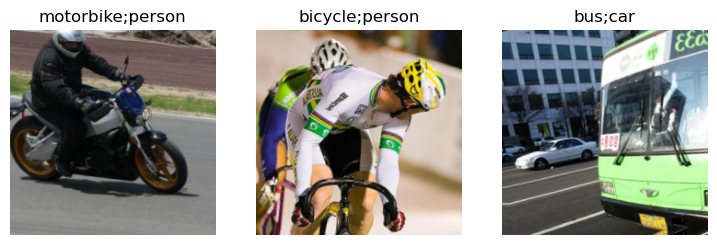

In [20]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = dblock.dataloaders(df, device="cpu") # remove device arg when not on mac
dls.show_batch(max_n=3)

# Image Localization

### Segmentation

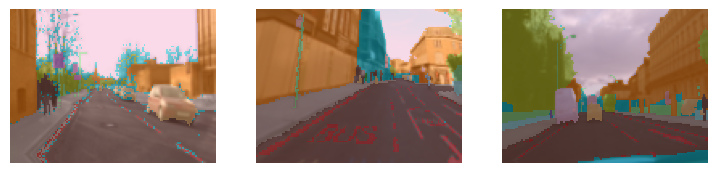

In [21]:
path = untar_data(URLs.CAMVID_TINY)

camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

dls = camvid.dataloaders(path/"images", device="cpu") # remove device arg when not on mac
dls.show_batch(max_n=3)

### Points - Regression

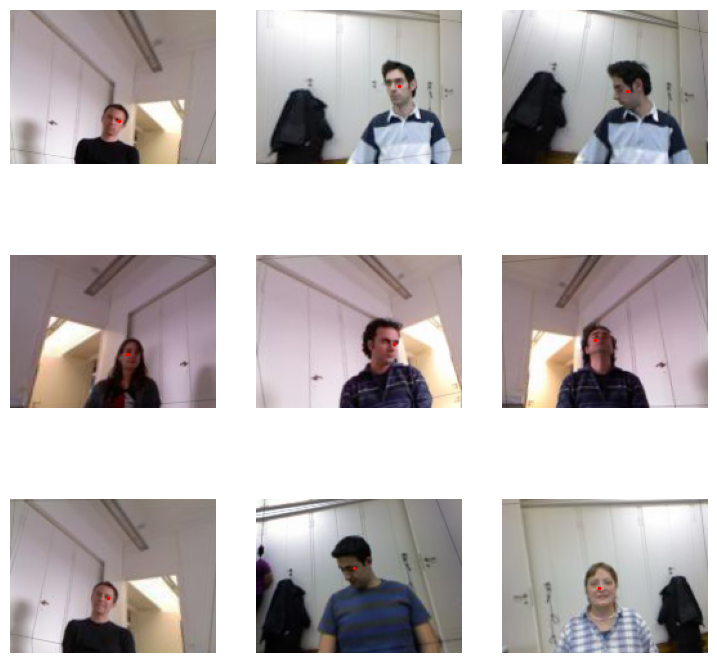

In [22]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = load_pickle(biwi_source/'centers.pkl')

biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

dls = biwi.dataloaders(biwi_source, device="cpu") # remove device arg when not on mac
dls.show_batch(max_n=9)

### Boxes

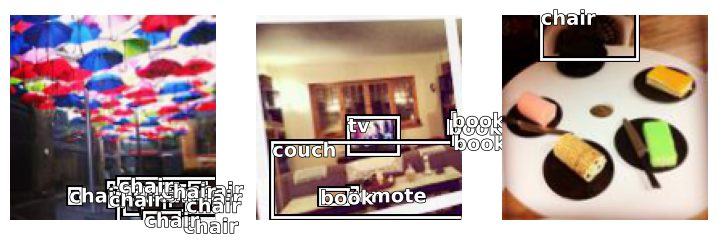

In [23]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

dls = coco.dataloaders(coco_source, device="cpu") # remove device arg when not on mac
dls.show_batch(max_n=3)

# NLP

### Text Generation

In [24]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
df.head(1)

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False


In [25]:
imdb_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)
dls.show_batch(max_n=1)

,text,text_
0,"xxbos xxmaj anita and xxmaj me seems to be little more than an excuse for xxmaj xxunk xxmaj xxunk , the author of the novel and screenplay , to air her prejudices , xxunk and general xxunk towards the xxmaj english . xxmaj the general sentiment of xxmaj indian xxunk over the xxmaj english in this film is foul . \n\n xxmaj the xxmaj english people in this film are portrayed as","xxmaj anita and xxmaj me seems to be little more than an excuse for xxmaj xxunk xxmaj xxunk , the author of the novel and screenplay , to air her prejudices , xxunk and general xxunk towards the xxmaj english . xxmaj the general sentiment of xxmaj indian xxunk over the xxmaj english in this film is foul . \n\n xxmaj the xxmaj english people in this film are portrayed as overweight"


### NLP - Text Classification

In [26]:
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72, vocab=dls.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter())

dls = imdb_clas.dataloaders(df, bs=64)
dls.show_batch(max_n=1)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative


# Tabular Data

In [27]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k


In [28]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))

In [29]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits, y_block=CategoryBlock)

/Users/cactus/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [30]:
dls = to.dataloaders()
dls.show_batch(max_n=1)

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Some-college,Widowed,Prof-specialty,Unmarried,White,False,47.000000,176239.000363,10.0,<50k
1,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,22.000000,136767.001071,9.0,<50k
2,Private,HS-grad,Divorced,Transport-moving,Not-in-family,White,False,28.000000,145284.000419,9.0,<50k
3,Private,Bachelors,Divorced,Adm-clerical,Not-in-family,White,False,51.000000,200575.999967,13.0,<50k
4,Local-gov,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,50.000000,153064.001438,9.0,>=50k
5,Self-emp-inc,Assoc-acdm,Married-civ-spouse,Craft-repair,Husband,White,False,59.000001,349909.994842,12.0,<50k
6,Self-emp-not-inc,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,False,40.000000,99651.002061,10.0,<50k
7,Private,Assoc-voc,Widowed,Exec-managerial,Unmarried,White,False,50.000000,198362.000058,11.0,<50k
8,Self-emp-not-inc,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,False,63.000000,33486.994593,4.0,<50k
9,Self-emp-not-inc,Bachelors,Married-spouse-absent,Prof-specialty,Not-in-family,White,False,55.999999,110238.002631,13.0,>=50k


In [31]:
# we can verify the numericalization
to.items.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,education-num_na
27580,-0.256163,5,-1.013701,12,-0.420505,5,9,4,5,Male,0,0,40,United-States,0,1
1209,2.600181,5,-0.005475,15,1.934715,3,11,1,5,Male,99999,0,50,United-States,1,1
22131,-1.427996,5,-0.234744,12,-0.420505,5,8,4,5,Female,0,0,40,United-States,0,1


In [32]:
# we can check the mapping of the text to numbers, as you can see there is no particular order, unless you specified one
to.classes['education']

['#na#', ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college']